In [1]:
# Notebook header: reproducibility & imports
RANDOM_SEED = 42

import os, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import joblib

# reproducible seeds
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# scikit-learn helpers
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc,
                             average_precision_score, classification_report,
                             ConfusionMatrixDisplay, RocCurveDisplay)

# plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

# Create output directories if they don't exist
os.makedirs('../models', exist_ok=True)

In [2]:
target_col = 'Attrition'
df = pd.read_csv('../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Drop constant columns and identifiers
df = df.drop(columns=['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'])

X = df.drop(columns=[target_col])
y = df[target_col].map({'Yes': 1, 'No': 0})

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1176, 30)
Test set shape: (294, 30)


In [4]:
# Identify column types
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Create preprocessing pipelines for each type
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine them in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any
)

In [5]:
# Append classifier to the preprocessor
pipe_dummy = Pipeline([('preprocessor', preprocessor),
                       ('classifier', DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED))])

pipe_lr = Pipeline([('preprocessor', preprocessor),
                    ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_SEED))])

pipe_dt = Pipeline([('preprocessor', preprocessor),
                    ('classifier', DecisionTreeClassifier(random_state=RANDOM_SEED))])

In [6]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
models = {'Dummy': pipe_dummy, 'LogisticRegression': pipe_lr, 'DecisionTree': pipe_dt}
results = {}

print("Running cross-validation...")
for name, pipeline in models.items():
    res = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    
    summary = {}
    for metric in scoring.keys():
        scores = res[f'test_{metric}']
        summary[f'{metric}_mean'] = np.mean(scores)
        summary[f'{metric}_std'] = np.std(scores, ddof=1)
    results[name] = summary
    print(f"Finished {name}.")

# Save and display results
baseline_df_cv = pd.DataFrame.from_dict(results, orient='index')
baseline_df_cv.to_csv('../tables/baseline_metrics_cv.csv')
baseline_df_cv

Running cross-validation...
Finished Dummy.
Finished LogisticRegression.
Finished DecisionTree.


,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
Dummy,0.838435,0.000306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.161565,0.000306
LogisticRegression,0.890310,0.021334,0.776350,0.083232,0.442105,0.107541,0.561011,0.109210,0.839189,0.032357,0.651440,0.068278
DecisionTree,0.795067,0.020287,0.357627,0.073900,0.357895,0.114103,0.356795,0.093222,0.618598,0.057766,0.238367,0.053019


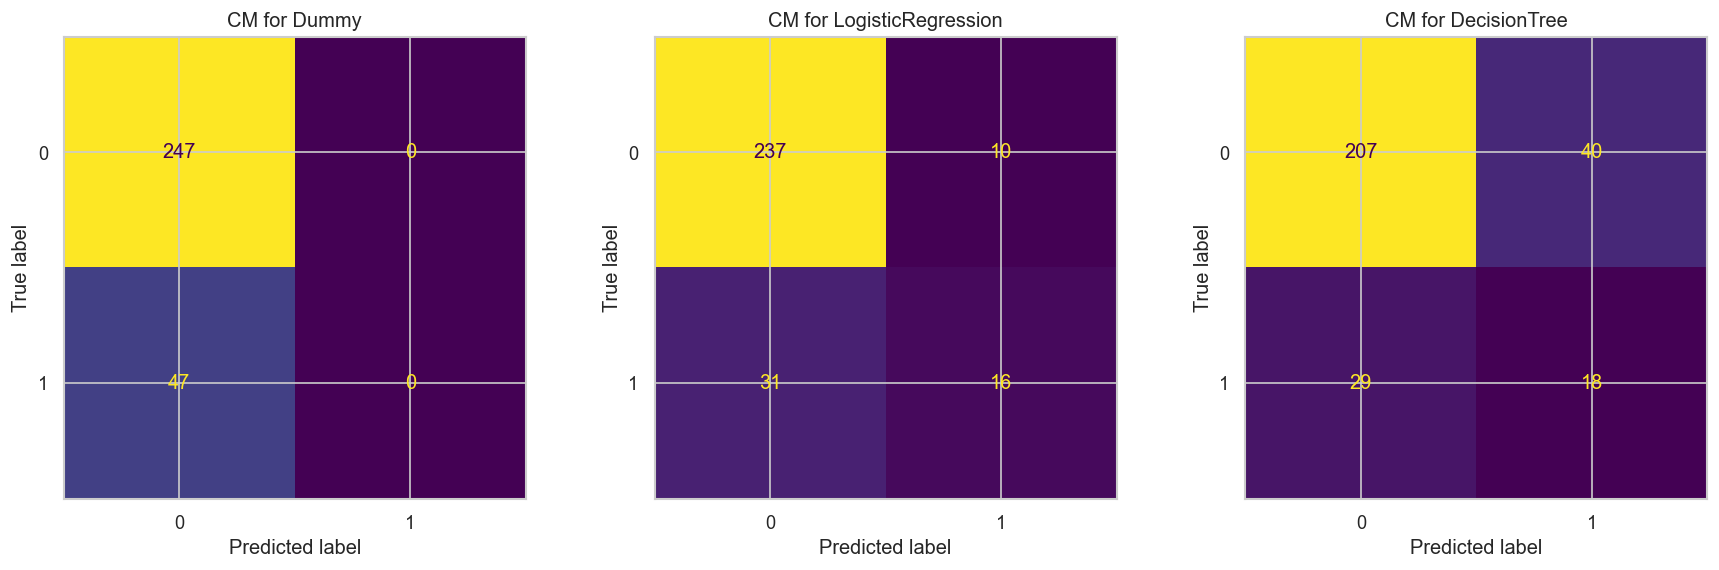

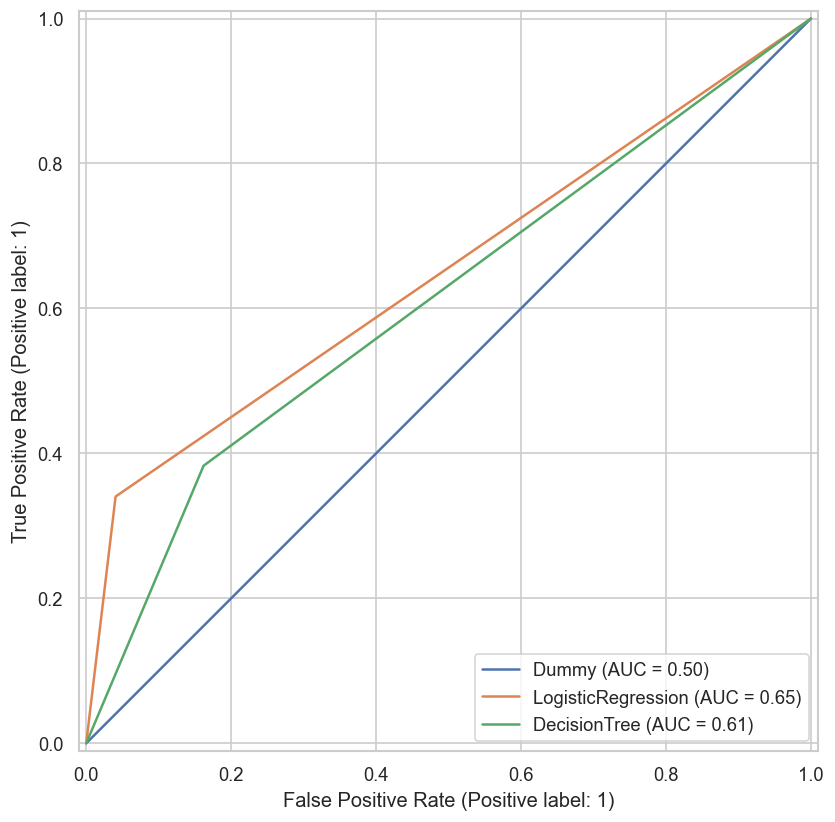

,accuracy,precision,recall,f1,roc_auc,pr_auc
Dummy,0.840136,0.000000,0.000000,0.000000,0.500000,0.159864
LogisticRegression,0.860544,0.615385,0.340426,0.438356,0.811526,0.583634
DecisionTree,0.765306,0.310345,0.382979,0.342857,0.610518,0.217495


In [7]:
holdout_results = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig_roc, ax_roc = plt.subplots(figsize=(8, 8))

for i, (name, pipeline) in enumerate(models.items()):
    # Fit on the full training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'pr_auc': average_precision_score(y_test, y_proba)
    }
    holdout_results[name] = metrics

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[i], colorbar=False)
    axes[i].set_title(f'CM for {name}')

    # Plot ROC curve
    RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax_roc, name=name)

plt.savefig('../figures/baseline_confusion_matrices.png', dpi=300, bbox_inches='tight')
ax_roc.figure.savefig('../figures/baseline_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Save holdout metrics and display
baseline_df_holdout = pd.DataFrame.from_dict(holdout_results, orient='index')
baseline_df_holdout.to_csv('../tables/baseline_holdout_metrics.csv')
baseline_df_holdout

In [8]:
joblib.dump(models['LogisticRegression'], '../models/baseline_logreg_pipeline.pkl')
print("Baseline Logistic Regression pipeline saved to models/.")

Baseline Logistic Regression pipeline saved to models/.
